# Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import random

# Seed 고정

In [2]:
np.random.seed(10)
random.seed(10)

# Create Job

In [3]:
job_number  = 100

In [4]:
job_time_interval = np.random.poisson(10,job_number-1)
job_create_time = [sum(job_time_interval[:i]) for i in range(len(job_time_interval)+1)]
print(job_time_interval)
print(job_create_time)

[13 11 10  7  6 13 12 15 10  9  9 11 11 13 15  5 10  7  8  8  8  9 13  9
 13 10  4  8  8  8 14 14 11 11  8  8 10 10  8  8  4 11  8  8 12  3  5 14
  7 10  6 11  7  7 15 11 11 11  6 12  9 10  5 11  7  8 12  9 11 11 12 10
 10  6 10  5  5  4 11 11  8  9  9 10 19 14  7 10 13  8  9 14 11  9 10  8
 13  7 11]
[0, 13, 24, 34, 41, 47, 60, 72, 87, 97, 106, 115, 126, 137, 150, 165, 170, 180, 187, 195, 203, 211, 220, 233, 242, 255, 265, 269, 277, 285, 293, 307, 321, 332, 343, 351, 359, 369, 379, 387, 395, 399, 410, 418, 426, 438, 441, 446, 460, 467, 477, 483, 494, 501, 508, 523, 534, 545, 556, 562, 574, 583, 593, 598, 609, 616, 624, 636, 645, 656, 667, 679, 689, 699, 705, 715, 720, 725, 729, 740, 751, 759, 768, 777, 787, 806, 820, 827, 837, 850, 858, 867, 881, 892, 901, 911, 919, 932, 939, 950]


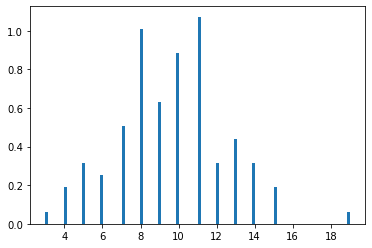

In [5]:
count, bins, ignored = plt.hist(job_time_interval, 100, density = True)
plt.show()

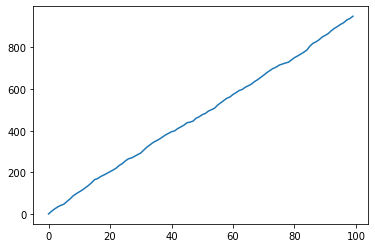

In [6]:
plt.plot(job_create_time)
plt.show()

# Job Queue

In [7]:
# class JobQueue(object):
    
#     def __init__(self):
#         self.job_q = queue.Queue()
#         self.job_number = 0
        
#     def insertJob(self, inout,  station_dest):
#         job = {"inout": inout, "station_dest": station_dest}
#         self.job_q.put(job)
#         self.job_number+=1

#     def getJob(self):
#         if self.job_q.empty():
#             return 
#         self.job_number-=1
#         return self.job_q.get()

In [8]:
def job_create(rack_location,total_job_location_list,time,total_job_information):
    job_location = [random.choice(rack_location)]
    if total_job_location_list.count(job_location)%2==0:
        total_job_information['{}'.format(time)] = ['in',job_location]
    else:
        total_job_information['{}'.format(time)] = ['out',job_location]
    total_job_location_list.append(job_location)
    return total_job_information

# AGV

In [172]:
class AGV(object):
    max_battery = 400
    CHARGING_STATION = [(2,9),(6,9)]    
    
    def __init__(self,agv_id,current_location,job_list,graph,current_tick=0):
        self.agv_id = agv_id
        self.battery = self.max_battery
        self.current_location = current_location
        self.job = None
        self.destination = None
        self.available = True
        self.current_tick = current_tick
        self.to_chaging_station = False
        self.charging = False
        self.job_list = job_list
        self.graph = graph

#     def __str__(self):
#         return 'agv_id:{}  job:{}  available:{}'.format(self.agv_id, self.job, self.available)
    
    def __str__(self):
        return 'agv_id:{}'.format(self.agv_id)
    
    def move_one_tick(self):
        if len(self.path) !=0:
            self.next_location = self.path[0]
            self.current_location = self.next_location
            del self.path[0]
            if len(self.path) ==0:
                self.available = True
            self.battery -=1
            self.current_tick +=1
        else:
            self.available = True
            
    def move_one_tick_for_charge(self):
        if len(self.path_for_charge) !=0:
            self.to_chaging_station = True
            self.next_location = self.path_for_charge[0]
            self.current_location = self.next_location
            del self.path_for_charge[0]
            self.battery -=1
            self.current_tick +=1
            if len(self.path_for_charge) ==0:
                self.to_chaging_station = False
                self.charging = True
                self.charging_agv()
        else:
            self.charging = True
    
    def get_job(self,job,astar_path):
        self.job = job
        self.path = astar_path
        self.available = False
        
    def go_to_charge(self,astar_path_to_charger):
        self.path_for_charge = astar_path_to_charger
        self.to_chaging_station = True
    
    
#     def agv_to_charging_station(self,battery_threshold):
#         if self.available == True and self.battery <= battery_threshold:
#             self.to_chaging_station = True

    def calculate_cost(self,agv_id,job,warehouse,INPUT_STATION,OUTPUT_STATION):
        if job['inout']=='in':
            cost = len(astar(warehouse,agv.current_location,INPUT_STATION))
        else:
            cost = len(astar(warehouse,agv.current_location,Rack_enterence[job['station_dest']]))
        return cost        
    
    def calculate_cost_for_charing_bid(self,warehouse,charging_station):
        cost = len(astar(warehouse,self.current_location,charging_station))
        return cost    
    
    def charging_agv(self):
        if self.charging == True:
            self.battery +=50
            if self.battery >= self.max_battery:
                self.battery = self.max_battery
                self.charging = False 
                self.available=True
                
    def select_job(self):
#         print(job_list)
        distance = []
        for job in job_list:
            if job[0] == 'in':
                distance.append(len(astar(warehouse,self.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job[1][0]])))
            else:
                distance.append(len(astar(warehouse,self.current_location,Rack_enterence[job[1][0]])+astar(warehouse,Rack_enterence[job[1][0]],OUTPUT_STATION)))
        min_distance = min(distance)
#         print(min_distance)
        select_job_before_bid = job_list[distance.index(min_distance)]
        return select_job_before_bid , min_distance
        
# 만약 distance가 같다면 먼저 온 순서대로 선택.
#         print(distance)
#         return select_job_before_bid
                
        
#     def calculate_bid(self):
    
    def drop_job(self):
        self.job = None
        self.available = True
        
        

In [173]:
def getAvailAGV(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery > battery_threshold]

In [174]:
def getnNeedChargeAgv(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery <= battery_threshold and agv.charging == False and agv.to_chaging_station == False]

In [175]:
job_list1 = [['in', [(1, 3)]],['in', [(1, 4)]],['out', [(1, 4)]]]
for job in job_list1:
    print(job)
    print(job[0])
    print(job[1][0])

['in', [(1, 3)]]
in
(1, 3)
['in', [(1, 4)]]
in
(1, 4)
['out', [(1, 4)]]
out
(1, 4)


In [176]:
agv1 = AGV("agv1",(0,9),job_list1,warehouse)
agv2 = AGV("agv2",(1,5),job_list1,warehouse)

In [177]:
Rack_enterence[(1,3)]

(0, 3)

In [178]:
print(astar(warehouse,agv1.current_location,Rack_enterence[job_list[0][1][0]])+[(1,2),(1,3)])

[(0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (9, 8), (9, 7), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (1, 2), (1, 3)]


In [179]:
print(agv1.select_job())
print(agv2.select_job())

(['in', [(1, 3)]], 20)
(['in', [(1, 3)]], 17)


In [180]:
agv1 = AGV("agv1",(0,9),job_list,warehouse)
agv2 = AGV("agv2",(3,9),job_list,warehouse)
agv3 = AGV("agv3",(6,9),job_list,warehouse)
agv4 = AGV("agv4",(9,9),job_list,warehouse)
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

In [181]:
print(astar(warehouse,agv1.current_location,Rack_enterence[job_list[0][1][0]]))

[(0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (9, 8), (9, 7), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2)]


In [186]:
if __name__ == '__main__':
    job_list = []
    for running_time in range(run_time+1):
        if running_time in job_create_time:
#             print("@@",running_time)
            job_list.append(total_job_information.get('{}'.format(running_time)))
            print(job_list)
#             print(len(job_list))
#             print('running time : {}, job_append : {}'.format(running_time,total_job_information.get('{}'.format(running_time))))
            agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
#             print(agv_avail)
            if len(agv_avail)!=0 and len(job_list)!=0:
                print("@@")
                selected_job = {}
                for agv in agv_avail:
                    selected_job[agv]=agv.select_job()
                print(selected_job)
#                 print('@@@@',sort(selected_job.items(), key = lambda x : x[1]))
                print(selected_job.sort(key=lambda x:x[1]))
                

[['in', [(8, 2)]]]
@@
{<__main__.AGV object at 0x0000014E3EC126A0>: (['in', [(8, 2)]], 22), <__main__.AGV object at 0x0000014E3EC123D0>: (['in', [(8, 2)]], 19), <__main__.AGV object at 0x0000014E3EC127C0>: (['in', [(8, 2)]], 22), <__main__.AGV object at 0x0000014E3EC123A0>: (['in', [(8, 2)]], 25)}


AttributeError: 'dict' object has no attribute 'sort'

In [183]:
if __name__ == '__main__':
    job_list = []
    for running_time in range(run_time+1):
        if running_time in job_create_time:
            print("@@",running_time)
            job_list.append(total_job_information.get('{}'.format(running_time)))
            print(job_list)
#             print('running time : {}, job_append : {}'.format(running_time,total_job_information.get('{}'.format(running_time))))
            agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
            print(agv_avail)
            if len(agv_avail)!=0 and len(job_list)!=0:
                selected_job = []
                for agv in agv_avail:
                    selected_job.append(agv.select_job())
                    print(selected_job)

@@ 0
[['in', [(8, 2)]]]
[<__main__.AGV object at 0x0000014E3EC126A0>, <__main__.AGV object at 0x0000014E3EC123D0>, <__main__.AGV object at 0x0000014E3EC127C0>, <__main__.AGV object at 0x0000014E3EC123A0>]
[(['in', [(8, 2)]], 22)]
[(['in', [(8, 2)]], 22), (['in', [(8, 2)]], 19)]
[(['in', [(8, 2)]], 22), (['in', [(8, 2)]], 19), (['in', [(8, 2)]], 22)]
[(['in', [(8, 2)]], 22), (['in', [(8, 2)]], 19), (['in', [(8, 2)]], 22), (['in', [(8, 2)]], 25)]
@@ 13
[['in', [(8, 2)]], ['in', [(1, 3)]]]
[<__main__.AGV object at 0x0000014E3EC126A0>, <__main__.AGV object at 0x0000014E3EC123D0>, <__main__.AGV object at 0x0000014E3EC127C0>, <__main__.AGV object at 0x0000014E3EC123A0>]
[(['in', [(1, 3)]], 20)]
[(['in', [(1, 3)]], 20), (['in', [(1, 3)]], 17)]
[(['in', [(1, 3)]], 20), (['in', [(1, 3)]], 17), (['in', [(1, 3)]], 20)]
[(['in', [(1, 3)]], 20), (['in', [(1, 3)]], 17), (['in', [(1, 3)]], 20), (['in', [(1, 3)]], 23)]


# Astar

In [28]:
class node:
    def __init__(self,parent=None, position = None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self,other):
        return self.position == other.position

In [29]:
def manhattan_distance(start_node,goal_node):
    dx = abs(start_node[0]-goal_node[0])
    dy = abs(start_node[1]-goal_node[1])
    return dx + dy

In [30]:
def astar(graph,start,goal):
    start_node = node(None,(start[1],start[0]))
    goal_node = node(None,(goal[1],goal[0]))
    open_list = []
    closed_list = []
    graph = [el for el in graph][::-1]
#     for i in graph:
#         print(i)
    
    open_list.append(start_node)
    while open_list:
        current_node = open_list[0]
        current_index = 0
        
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        if current_node == goal_node:
            path = []
            current = current_node
            while current is not None:
#                 x,y = current.position
#                 graph[x][y] = 9
                path.append((current.position[1],current.position[0]))
                current = current.parent
                
            return path[::-1]
        
        children = []
        for new_position in [(0,1),(1,0),(-1,0),(0,-1)]:
            node_position = (current_node.position[0]+new_position[0],
                             current_node.position[1]+new_position[1])
            within_range = [
                node_position[1]>len(graph)-1,
                node_position[1]<0,
                node_position[0]>len(graph[len(graph)-1])-1,
                node_position[0]<0]
            if any(within_range):
                continue
            if graph[node_position[0]][node_position[1]] !=0:
                continue
            
            new_node = node(current_node, node_position)
            children.append(new_node)
        
        for child in children:
            if child in closed_list:
                continue
            child.g = current_node.g+1
            child.h = manhattan_distance(child.position,goal_node.position)
            child.f = child.g + child.h
            
            if len([open_node for open_node in open_list
                   if child == open_node and child.g>open_node.g]) > 0:
                continue
            open_list.append(child)

# Warehouse, Rack, Charging_station

In [31]:
def make_warehouse(row,col):
    warehouse = [[0]*col for i in range(row)]
    return warehouse 

In [32]:
def set_rack(warehouse,rack_location):
    for idx, row in enumerate(warehouse):
        warehouse[idx] =  [1 if (ix, ROW -1 - idx) in rack_location else 0 for ix,col in enumerate(warehouse[idx])]

In [33]:
def get4Ways(point):
    return [(point[0],point[1]+1), (point[0]+1,point[1]),
            (point[0],point[1]-1), (point[0]-1,point[1])]

In [34]:
def set_charging_station(warehouse,CHARGING_STATION,ROW,COL):
    for charging_spot in CHARGING_STATION:
        warehouse[ROW-1-charging_spot[1]][charging_spot[0]]=2
    return warehouse

# Make warehouse, Rack, Rack enterence, Station

In [35]:
ROW, COL = 10,10
warehouse = make_warehouse(ROW,COL)
INPUT_STATION = (3,0)
OUTPUT_STATION = (6,0)
CHARGING_STATION = [(2,9),(7,9)]   
rack_location =  [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
                  (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), 
                  (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), 
                  (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), 
                  (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 
                  (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


In [36]:
set_rack(warehouse,rack_location)
# set_charging_station(warehouse,CHARGING_STATION,ROW,COL)

In [37]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

# 실험

### Simulation condition

In [38]:
# jobQ = JobQueue()
# jobQ_for_simulation = JobQueue()
run_time = 20
total_job_location_list = []
select_agv = []
charging_agvs = []
moving_for_charge_agvs = []
battery_threshold = 100
total_job_information = {}
job_list = []

### Create AGV

In [39]:
agv1 = AGV("agv1",(0,9),job_list,warehouse)
agv2 = AGV("agv2",(3,9),job_list,warehouse)
agv3 = AGV("agv3",(6,9),job_list,warehouse)
agv4 = AGV("agv4",(9,9),job_list,warehouse)
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

### Created Job 확인

In [40]:
for time in range(run_time+1):
    if time in job_create_time:
        job_create(rack_location,total_job_location_list,time,total_job_information)
print(total_job_information)
print(len(total_job_information))

{'0': ['in', [(8, 2)]], '13': ['in', [(1, 3)]]}
2


### Main 함수 

In [41]:
# if __name__ == '__main__':

In [42]:
if __name__ == '__main__':
    job_list = []
    for running_time in range(run_time+1):
        if running_time in job_create_time:
            print("@@",running_time)
            job_list.append(total_job_information.get('{}'.format(running_time)))
            print(job_list)
#             print('running time : {}, job_append : {}'.format(running_time,total_job_information.get('{}'.format(running_time))))
            agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
            print(agv_avail)
            if len(agv_avail)!=0 and len(job_list)!=0:
                selected_job = []
                for agv in agv_avail:
                    selected_job.append(agv.select_job)
                print(selected_job)

@@ 0
[['in', [(8, 2)]]]
[<__main__.AGV object at 0x0000014E3EC5D8B0>, <__main__.AGV object at 0x0000014E3EC5DB50>, <__main__.AGV object at 0x0000014E3EC5D2E0>, <__main__.AGV object at 0x0000014E3EC5DD00>]
[<bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5D8B0>>, <bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5DB50>>, <bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5D2E0>>, <bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5DD00>>]
@@ 13
[['in', [(8, 2)]], ['in', [(1, 3)]]]
[<__main__.AGV object at 0x0000014E3EC5D8B0>, <__main__.AGV object at 0x0000014E3EC5DB50>, <__main__.AGV object at 0x0000014E3EC5D2E0>, <__main__.AGV object at 0x0000014E3EC5DD00>]
[<bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5D8B0>>, <bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5DB50>>, <bound method AGV.select_job of <__main__.AGV object at 0x0000014E3EC5D2E0>>, <bound method AGV.selec

In [43]:
print(job_list)

[['in', [(8, 2)]], ['in', [(1, 3)]]]


In [44]:
if __name__ == '__main__':
    for running_time in range(run_time+1):
        if len(moving_for_charge_agvs)!=0:
            for moving_agvs in moving_for_charge_agvs:
                moving_agvs.move_one_tick_for_charge()
                print("running time : {}, moving agv for charging : {}, current location : {}".format(running_time, moving_agvs,moving_agvs.current_location))
                if moving_agvs.charging == True:
                    moving_for_charge_agvs.remove(moving_agvs)

        agv_need_charge = getnNeedChargeAgv(AGV_LIST,battery_threshold) 
        if len(agv_need_charge)==0:
            print('A time : {}, There is no new AGVs for charge'.format(running_time))
        else:
            print('B There is new AGVs for charging {}'.format(agv_need_charge))          
            for agv_for_charge in agv_need_charge:
                bid_for_charge_list = []
                for charger in CHARGING_STATION:
                    bid_for_charge_list.append(agv_for_charge.calculate_cost_for_charing_bid(warehouse,charger))
                min_charger_bid = min(bid_for_charge_list)
                target_charger = CHARGING_STATION[bid_for_charge_list.index(min_charger_bid)]
                astar_path_to_charger = astar(warehouse,agv_for_charge.current_location,target_charger)
                agv_for_charge.go_to_charge(astar_path_to_charger)
                moving_for_charge_agvs.append(agv_for_charge)      
    #         print("###",moving_for_charge_agvs)

    #       #사용가능한 agv와 job이 있을때 
        if running_time in job_create_time:
            print("@@@@@@@@@@@@@@@@@",running_time)
            jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
            agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
            print('C running_time : {} , agv_avail : {}'.format(running_time,agv_avail))
            if len(agv_avail)!=0 and jobQ.job_number !=0:
                if running_time ==0 or len(select_agv)==0:
                    auctioneer = random.choice(agv_avail)
                else:
                    auctioneer = select_agv[-1]
                job = jobQ.getJob()
                bid_list = []
                for agv in agv_avail:
                    bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
                min_bid = min(bid_list)
                target_agv = agv_avail[bid_list.index(min_bid)]
                if job['inout']=='in':
                    astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
                else:
                    astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
                target_agv.get_job(job,astar_path)
                select_agv.append(target_agv)
                print("D running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
        #           print(auctioneer)
                for moving_agv in set(select_agv):
                    moving_agv.move_one_tick()
                    if len(moving_agv.path)==0:
                        select_agv.remove(moving_agv)
                    print("E time : {}, moving agv : {}, battery : {}, current location : {}".format(running_time,moving_agv,moving_agv.battery,moving_agv.current_location))
            else:
                for moving_agv in select_agv:
                    moving_agv.move_one_tick()
                    if len(moving_agv.path)==0:
                        select_agv.remove(moving_agv)
                    print("F",running_time,moving_agv,moving_agv.battery,moving_agv.current_location)            


    # #         elif len(agv_avail) == 0 and jobQ.job_number = 0  # move one tick 
    # #         elif len(agv_avail) == 0 and jobQ.job_number !=0  # move one tick 
    # #         elif len(agv_avail) !=0 and jobQ.job_number = 0   # move one tick 

        else:
            agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
            if len(agv_avail)!=0 and jobQ.job_number !=0:
                job = jobQ.getJob()
                bid_list = []
                for agv in agv_avail:
                    bid_list.append(agv.calculate_cost(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
                min_bid = min(bid_list)
                target_agv = agv_avail[bid_list.index(min_bid)]
                if job['inout']=='in':
                    astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
                else:
                    astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
                target_agv.get_job(job,astar_path)
                select_agv.append(target_agv)
                print("G running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
                for moving_agvs in set(select_agv):
                    moving_agvs.move_one_tick()
                    print("H running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
                    if len(moving_agvs.path) ==0:
                        select_agv.remove(moving_agvs)
        #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)

            else:
                for moving_agvs in set(select_agv):
                    moving_agvs.move_one_tick()
                    print("I running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
                    if len(moving_agvs.path) ==0:
                        select_agv.remove(moving_agvs)       

A time : 0, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 0


NameError: name 'jobQ' is not defined

In [45]:
a = 1
b = [0,1,2,3]

In [46]:
class akk:
    def __init__(self,a,b):
        self.b = b
        self.a = a
        
    def google():
        b.append('c')
    def __str__(self):
        return "b:{}".format(b)

In [47]:
bb = akk(a,b)

In [48]:
bb.google()

TypeError: google() takes 0 positional arguments but 1 was given

In [49]:
k = {'1':(1,1),'2':(2,2)}

In [50]:
print(len(k))

2
